# Digit Recognition using CNN (99.6%)

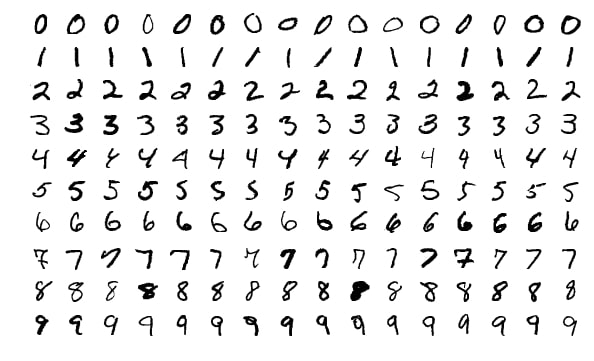

**by Ewan Wallace**

This CNN uses a LeNet architecture, data augmentation, hyperparameter tuning and ensembling to achieve an accuracy of 99.567% - 94th on the Kaggle leaderboard of over 3300 submissions.

The MNIST is a well-known image recognition dataset, so much so that it is often used to benchmark new models. The dataset contains handwritten numbers from 0-9. This CNN uses a LeNet architecture, data augmentation, hyperparameter tuning and ensembling to achieve an accuracy of 99.567% - 94th on the Kaggle leaderboard of over 3300 submissions.

## Contents

* **1. Introduction**
* **2. Data Preparation and Pre-processing**
 * 2.1 Loading Data
 * 2.2 Checking for Missing Values
 * 2.3 Data and Target Class Visualizations
 * 2.4 Creating Training and Validation Sets
 * 2.5 Pre-processing Pipelines
 * 2.6 Custom F1, Recall and Precision Metrics
* **3. Building Network and Training**
 * 3.1 Building Network
 * 3.2 Training Network
 * 3.3 Validation Results
 * 3.4 Review of Incorrectly Classified Examples
 * 3.5 Visualizing Filters and Feature-maps
* **4. Data Augmentation**
 * 4.1 Creating an ImageDataGenerator
 * 4.2 Augmented Images Visualized
 * 4.3 Training Network on Augmented Data
 * 4.4 Validation Results on Augmented Data
* **5. Hyper-parameter Tuning**
 * 5.1 Building Hyper-parameter Model
 * 5.2 Hyper-parameter Hyperband Search
 * 5.3 Hyper-parameter Hyperband Results
* **6. Ensembling**
 * 6.1 Ensembling Top Models from Hyper-parameter Tuning
 * 6.2 Ensembling on Best Model
* **7. Conclusion**
 * 7.1 Results Summary
  * 7.2 Submission Values

# 1. Introduction

The MNIST dataset is a well known digit recognition dataset and an excellent way to understand the use of convolutional neuarl networks (CNNs). Here we will use a LeNet model architecture and explore techniques such as data augmentation, hyper-parameter tuning (using keras tuner) and ensembling to find the best possible model. This model achieves an accuracy of 99.567% on an unseen test set. This ranks at 94th out of all 3,727 entries to the MNIST Kaggle competitions (as of 11.03.23).

In [ ]:
import numpy as np
import pandas as pd

import random 
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

In [ ]:
def set_seed(seed=10):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  tf.experimental.numpy.random.seed(seed)
  tf.keras.utils.set_random_seed(seed)
  # When running on the CuDNN backend, two further options must be set
  # os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
  # os.environ['TF_DETERMINISTIC_OPS'] = '1'
  # Set a fixed value for the hash seed
  os.environ["PYTHONHASHSEED"] = str(seed)
  print(f"Random seed set as {seed}")

# 2. Data Preparation and Pre-Processing

## 2.1 Loading Data

Neural networks can run an order of magnitude faster on a GPU than a CPU (depending on specs) so I'd highly recommend setting up the GPU on your own laptop to interact with tensorflow [hyper-link this] or using an online GPU like Google Colab as I have here.

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
project_path = '/content/drive/MyDrive/Colab Notebooks/mnist/'
test = pd.read_csv(project_path + 'mnist_test.csv')
train = pd.read_csv(project_path + 'mnist_train.csv')

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The input data is given as a single csv file with 785 columns. The first column gives the number displayed in the image (label) and the remaining columns give a greyscale value for each pixel in the image - from white (0) to black (255). Each row of 784 pixels will then be reshaped into an28x28 array to give an image.

## 2.2 Missing Values

In [ ]:
test.isna().sum().sum()

0

In [ ]:
train.isna().sum().sum()

0

There are no missing values. Let's continue.

## 2.3 Data & Target Class Visualisations

In [ ]:
y = train.iloc[:,0]  # label
X = train.iloc[:,1:]  # pixel columns

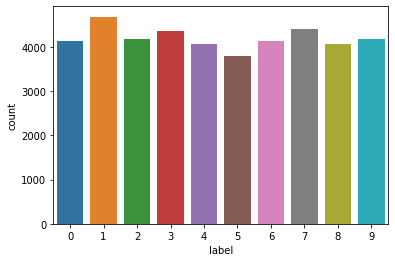

In [ ]:
sns.countplot(data=train, x=y)
plt.show()

We can see that the labels are roughly evenly distributed among the training set. This is good as it allows makes the dataset easier to train on.

This row displays the number 8


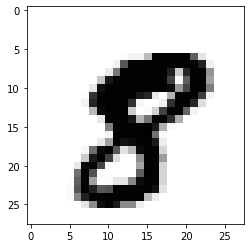

In [ ]:
# Example of input and desired output
n = 10
print(f'This row displays the number {y.iloc[n]}')

img = X.iloc[n].values
plt.imshow(img.reshape(28,28), cmap = 'Greys') # reshape 756 columns into a 28 x 28 density matrix
plt.show()

As explained above, a single row has been reshaped to a 28 x 28 black and white image.

## 2.4 Creating Training and Validation Sets

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)
print(X_train.shape, X_val.shape, test.shape)

(37800, 784) (4200, 784) (28000, 784)


Since the training set is fairly large (42,000 images) and there are only 10 categories, a validation set of 10% will be sufficient.

## 2.5 Pre-Processing Pipleines

Before we begin training any models we must prepare the inputs. A MinMaxScaler is used as NNs prefer data scaled to [0,1]. X is then reshaped to a 28 x 28 array to represent an image. As it is only black and white we only need one layer (channel) to the matrix. y is one-hot encoded.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# scale data to [0,1]
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
test = scaler.transform(test)

In [ ]:
# reshape inputs to 28x28 array
X_train = X_train.reshape(-1, 28, 28, 1)
X_val = X_val.reshape(-1, 28, 28, 1)
test = test.reshape(-1, 28, 28, 1)

In [ ]:
# one hot encode answers
y_train = pd.get_dummies(y_train).to_numpy()
y_val = pd.get_dummies(y_val).to_numpy()

## 2.6 Custom f1, Recall and Precision Metrics

Keras does not contain F1-score, recall or precision as pre-defined metrics so instead we shall define them as custom functions for our training. Precision is measurement of false positives and recall is a measurement of false negatives. The F1 score provides a single metric that combining the two.

Epsilon in used to avoid the infinite value error when dividing by zero.

In [ ]:
from keras import backend as K

# Precision (using keras backend)
def precision(y_true, y_pred):
    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_positives = K.sum(K.clip((1-y_true) * y_pred, 0, 1))

    p = true_positives / (true_positives + false_positives + K.epsilon())
    return p

# Recall (using keras backend)
def recall(y_true, y_pred):
    threshold = 0.5 #Training threshold 0.5
    y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

    true_positives = K.sum(K.clip(y_true * y_pred, 0, 1))
    false_negatives = K.sum(K.clip(y_true * (1-y_pred), 0, 1))

    r = true_positives / (true_positives + false_negatives + K.epsilon())
    return r

# F1-score (using keras backend)
def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f1 = 2 * ((p * r) / (r+p+K.epsilon()))
    return f1

# 3. Building & Training Network

Models in this script will follow an adapted LeNet architecture. LeNet was first proposed in 1998 but even now remains one of the more simple yet accurate architectures. LeNet traditionally contains several pairs of convolutional and pooling layers, followed by one or more flattened fully connected layers.

In this adaptation we have added batch normalisation and dropout layers after each pair to prevent too much computational expense and reduce the chance of overfitting.

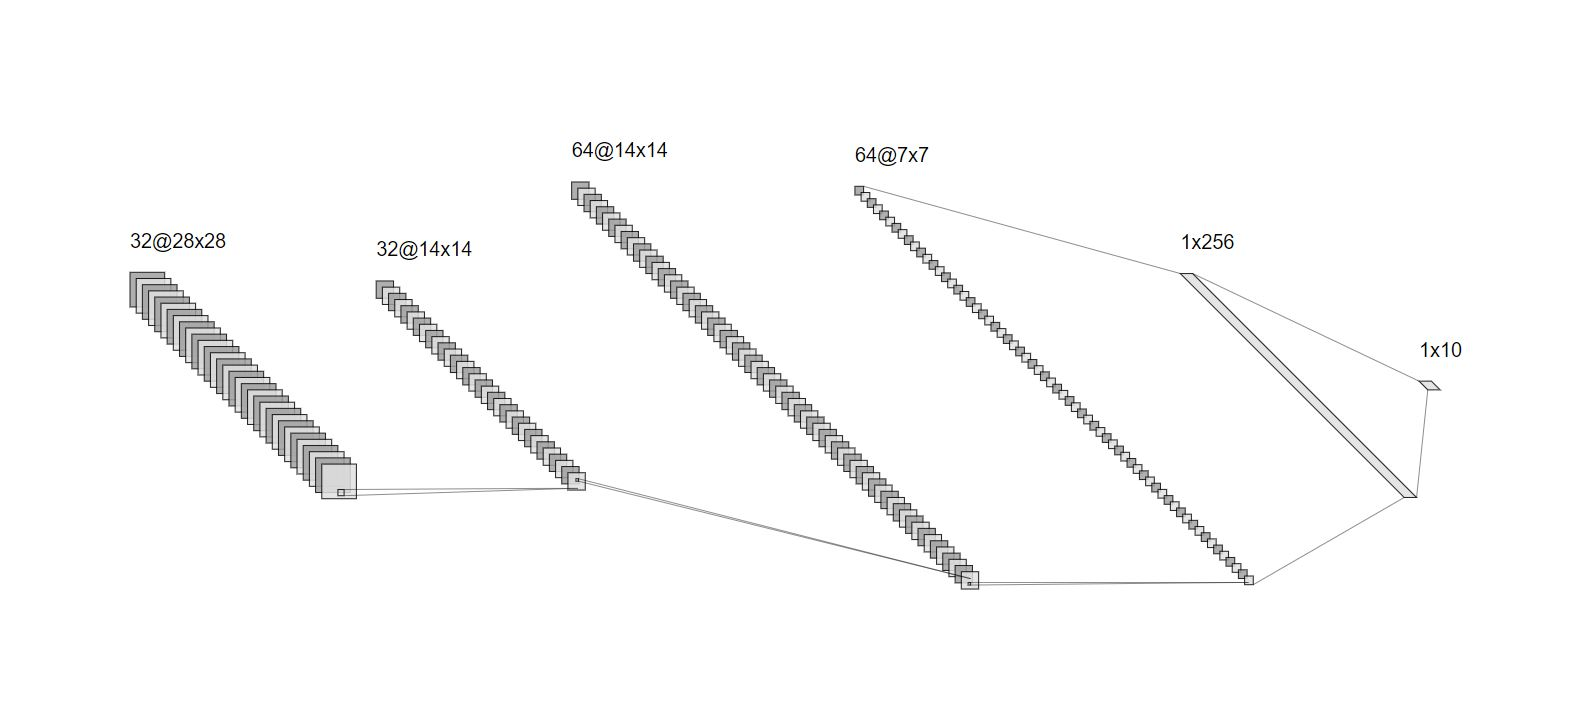

## 3.1 Building Network

In our initial model we shall use 2 convolutional blocks, followed by a single flattened fully connected layer. A cross-entropy loss function and adam optimiser are used and accuracy is used in addition to our custom metrics.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, BatchNormalization, Dropout

def build_model():

    set_seed()
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(5,5), strides=(1,1), padding='SAME', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(5,5), padding='SAME', activation='relu'))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=keras.losses.CategoricalCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=0.00001),
                  metrics=['accuracy', f1, recall, precision])

    return model

In [ ]:
model = build_model()
model.summary()

Random seed set as 10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (Non

## 3.2 Training Network

Now that our model is built, we can have some fun.

In [ ]:
batch_size=32

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=10, min_delta=0.005)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', patience = 3)

In [ ]:
%%time
filepath = project_path + 'models/model_1.h5'
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=40,
                    batch_size=batch_size,
                    callbacks=[early_stopping,
                               reduce_lr,
                               model_checkpoint]
                    )

Epoch 1/40
1182/1182 [==============================] - 21s 7ms/step - loss: 1.4665 - accuracy: 0.5397 - f1: 0.4255 - recall: 0.4201 - precision: 0.4378 - val_loss: 0.4890 - val_accuracy: 0.8586 - val_f1: 0.7506 - val_recall: 0.7777 - val_precision: 0.7263 - lr: 1.0000e-05
Epoch 2/40
1182/1182 [==============================] - 9s 8ms/step - loss: 0.6157 - accuracy: 0.7995 - f1: 0.7225 - recall: 0.7410 - precision: 0.7057 - val_loss: 0.3026 - val_accuracy: 0.9114 - val_f1: 0.8600 - val_recall: 0.8838 - val_precision: 0.8380 - lr: 1.0000e-05
Epoch 3/40
1182/1182 [==============================] - 9s 7ms/step - loss: 0.4284 - accuracy: 0.8631 - f1: 0.8095 - recall: 0.8281 - precision: 0.7923 - val_loss: 0.2426 - val_accuracy: 0.9271 - val_f1: 0.8930 - val_recall: 0.9100 - val_precision: 0.8769 - lr: 1.0000e-05
Epoch 4/40
1182/1182 [==============================] - 7s 6ms/step - loss: 0.3342 - accuracy: 0.8954 - f1: 0.8558 - recall: 0.8743 - precision: 0.8385 - val_loss: 0.1912 - val_acc

In [ ]:
model.load_weights(filepath)

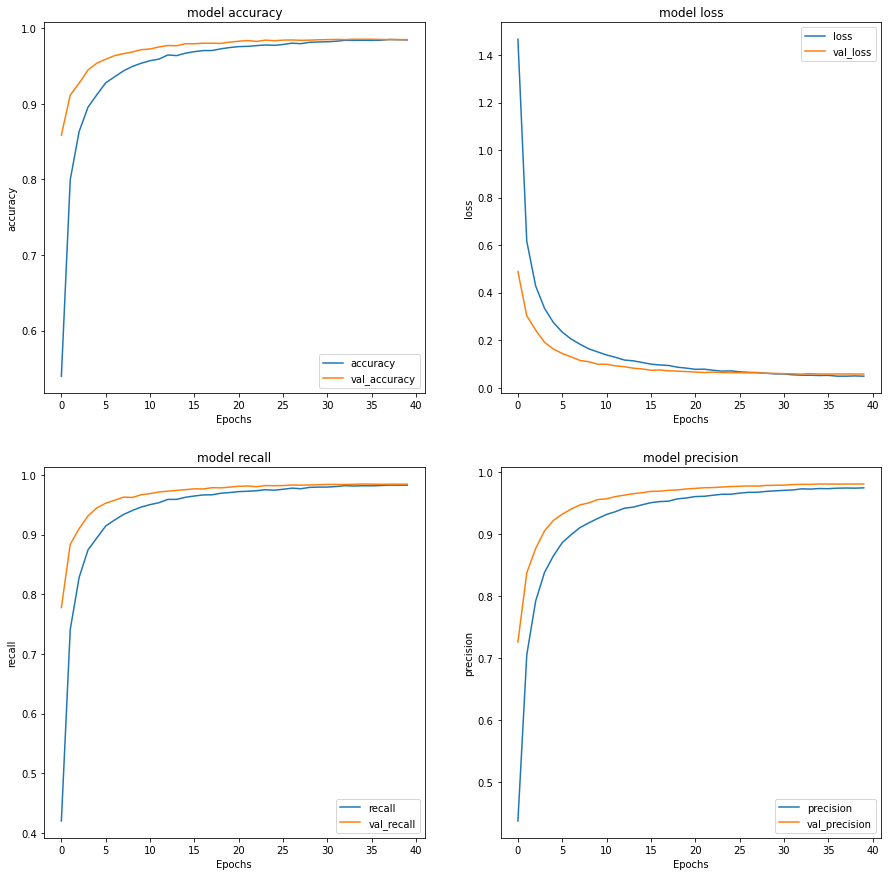

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

metrics = ['accuracy', 'loss', 'recall', 'precision']

for i, metric in enumerate(metrics):
    ax = axs.reshape(-1)[i]
    ax.plot(history.history[metric], label=metric)
    ax.plot(history.history['val_'+metric], label='val_'+metric)
    ax.set_title('model '+metric)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    ax.legend()

plt.show()

For a first model, the metric graphs above seem to be coverging nicely, however in the last ~10 epochs or so there is overfitting in the loss function. This is because this is the metric that is being minimised by the model.

## 3.3 Validation Results

Now we have a model, we can make some predictions using our validation set.

In [ ]:
y_val_pred = np.argmax(model.predict(X_val), axis=1)
y_val_ans = np.argmax(y_val, axis=1)

132/132 [==============================] - 0s 2ms/step


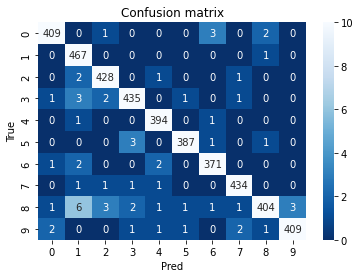

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_val_ans, y_val_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues_r', fmt='g', vmax=10)
plt.title('Confusion matrix')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

The confusion matrix looks really good as well with most predictions along the diagonal and only a few errors here and there.

In [ ]:
from sklearn.metrics import accuracy_score
model_1_score = accuracy_score(y_val_ans, y_val_pred)
results_dict = {'initial model (overfitting)': model_1_score}
print(f'Model Accuracy = {model_1_score:.4f}')

Model Accuracy = 0.9852


This is a good start for our first model with a nice high accuracy. However we can get a better understanding of how the model works by looking at where its misclassifying images.

## 3.4 Review of Incorrectly Classified Examples

In [ ]:
incorrect_matrix = cf_matrix
for i in range(len(incorrect_matrix)):
    incorrect_matrix[i,i]=0
indices = np.where(incorrect_matrix == incorrect_matrix.max())
predicted_val = indices[1][0]
true_val = indices[0][0]
n_incorrect = incorrect_matrix[true_val, predicted_val]
print(f'The most common error was predicted a {predicted_val} when the true value was {true_val}. This mistake was made {n_incorrect} times.')

The most common error was predicted a 1 when the true value was 8. This mistake was made 6 times.


In [ ]:
incorrect_examples = X_val[(y_val_ans==true_val) & (y_val_pred==predicted_val)]
incorrect_examples = incorrect_examples.reshape(-1, 28, 28)

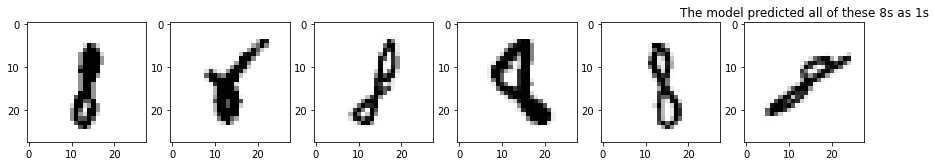

In [ ]:
fig, axs = plt.subplots(ncols=n_incorrect, figsize=(15,5))

for i in range(n_incorrect):
    ax = axs.reshape(-1)[i]
    ax.imshow(incorrect_examples[i], cmap = 'Greys')
fig.suptitle(f'The model predicted all of these {true_val}s as {predicted_val}s')
plt.show()

Just by looking, it is understandable why the model might confuse these images and misclassify them. This gives us a chance to make some changes to the model through data augmentation and hyper-parameter tuning to improve performance.

## 3.5 Visualising Filter and Feature Maps

In [ ]:
# tbc

# 4. Data Augmentation

Data augmentation takes your initial training set and applies small changes to the images (e.g. rotation, zooming in/out, stretching x/y axis) and then trains on these augmented images. This provides an even larger training set and makes the overfitting we saw in our first model much less likely as the augmented model is more generalisable. The flip side is the model will now take slightly longer to train.

## 4.1 Creating an ImageDataGenertor

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

ImageDataGenerator is a brilliant class in keras, which allows us to augment images in real-time while our model is training. This means we can pass it as input to the model, and new augmented images will be generated in batches on the go.

In [ ]:
datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range = 0.1
                             )
# removed horizontal and vertical flip as these negatively impacted performance.

In [ ]:
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

In [ ]:
steps_per_epoch = train_generator.n // train_generator.batch_size
steps_per_epoch

1181

In [ ]:
print(train_generator.n, train_generator.batch_size)

37800 32


## 4.2 Augmented Images Visualised

In [ ]:
# tbc

## 4.3 Training Network on Augmented Data

In [ ]:
model2 = build_model()

Random seed set as 10


In [ ]:
%%time
filepath = project_path + 'models/model_2.h5'
model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)

history2 = model2.fit(train_generator,
                      validation_data=(X_val, y_val),
                      epochs=100,
                      batch_size=batch_size,
                      callbacks=[early_stopping,
                                reduce_lr,
                                model_checkpoint]
                      )

Epoch 1/100
1182/1182 [==============================] - 25s 19ms/step - loss: 2.0382 - accuracy: 0.3583 - f1: 0.2273 - recall: 0.2028 - precision: 0.2708 - val_loss: 0.7213 - val_accuracy: 0.8321 - val_f1: 0.5947 - val_recall: 0.6054 - val_precision: 0.5861 - lr: 1.0000e-05
Epoch 2/100
1182/1182 [==============================] - 28s 24ms/step - loss: 1.2034 - accuracy: 0.6003 - f1: 0.4574 - recall: 0.4495 - precision: 0.4688 - val_loss: 0.4127 - val_accuracy: 0.9036 - val_f1: 0.7953 - val_recall: 0.8348 - val_precision: 0.7601 - lr: 1.0000e-05
Epoch 3/100
1182/1182 [==============================] - 21s 17ms/step - loss: 0.8898 - accuracy: 0.7045 - f1: 0.5953 - recall: 0.6043 - precision: 0.5881 - val_loss: 0.2867 - val_accuracy: 0.9390 - val_f1: 0.8751 - val_recall: 0.9091 - val_precision: 0.8438 - lr: 1.0000e-05
Epoch 4/100
1182/1182 [==============================] - 21s 18ms/step - loss: 0.6890 - accuracy: 0.7769 - f1: 0.6855 - recall: 0.7027 - precision: 0.6701 - val_loss: 0.227

In [ ]:
model2.load_weights(filepath)

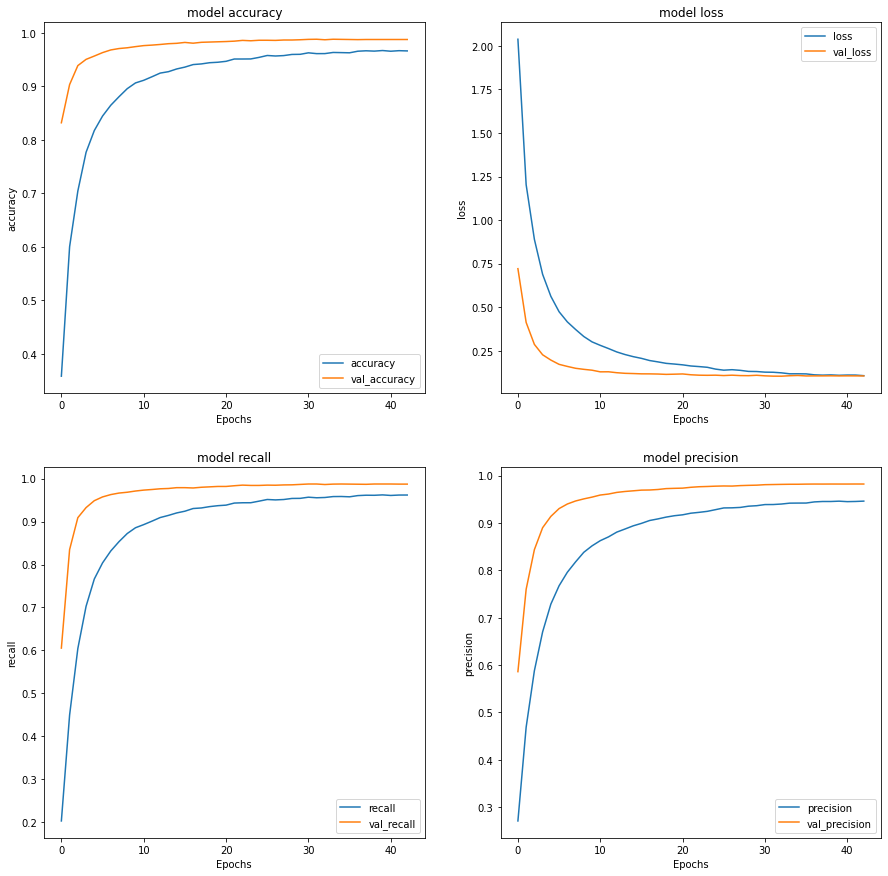

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

for i, metric in enumerate(metrics):
    ax = axs.reshape(-1)[i]
    ax.plot(history2.history[metric], label=metric)
    ax.plot(history2.history['val_'+metric], label='val_'+metric)
    ax.set_title('model '+metric)
    ax.set_xlabel('Epochs')
    ax.set_ylabel(metric)
    ax.legend()

plt.show()

The validation plots here converge to the final value much more quickly here than the training values. This is because the training set is constantly being altered by ImageDataGenerator to prevent it overfitting.

## 4.4 Validation Results on Augmented Data

In [ ]:
y_val_pred = np.argmax(model2.predict(X_val), axis=1)

132/132 [==============================] - 1s 4ms/step


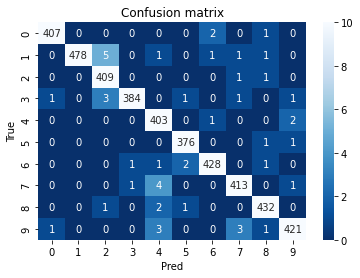

In [ ]:
cf_matrix = confusion_matrix(y_val_ans, y_val_pred)
sns.heatmap(cf_matrix, annot=True, cmap='Blues_r', fmt='g', vmax=10)
plt.title('Confusion matrix')
plt.xlabel('Pred')
plt.ylabel('True')
plt.show()

In [ ]:
model_2_score = accuracy_score(y_val_ans, y_val_pred)
results_dict['data augmented model'] = model_2_score
print(f'Model Accuracy = {model_2_score:.4f}')

Model Accuracy = 0.9883


While this may seem like a modest improvement over the initial model, it has actually reduced the error by 20%!

# 5. Hyperparameter Tuning

Another way of improving our model it to tune hyperparameters. We have a choice of several hyperparameters, such as the model optimiser, activation functions or loss function. However, here we will optimise the model architecture as this has a good track record of giving the greatest improvements.

In [ ]:
!pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.4 MB/s eta 0:00:00


## 5.1 Building Hyper-parameter Model

In [ ]:
import keras_tuner as kt

def build_model_hp(hp, seed=10):

    set_seed(seed)
    dropout = hp.Choice('conv_block_dropout', [0.125,0.25,0.375,0.5])
    conv_kernel_size = hp.Choice('conv_kernel_size', [5])
    # Kernel size 5 is optimal after multiple testing experiments

    n_layers = hp.Choice('n_conv_blocks', [2,3,4])
    filter_choice = hp.Choice('filter_combination_choice', [0,1,2,3])

    filter_combinations = {2:[[16,32],[32,64],[64,128],[128,256]],
                           3:[[16,32,48],[16,32,64],[32,64,128],[64,128,256]],
                           4:[[16,16,32,32],[32,32,64,64],[64,64,128,128],[128,128,256,256]]
                           }

    filter_settings = filter_combinations[n_layers][filter_choice]

    model = Sequential()
    model.add(Conv2D(filters=filter_settings[0],
                     kernel_size=conv_kernel_size,
                     strides=(1,1),
                     padding='SAME',
                     activation='relu',
                     input_shape=(28, 28, 1) ))

    for i in range(1, n_layers):
        model.add(Conv2D(filters=filter_settings[i],
                         kernel_size=conv_kernel_size,
                         strides=(1,1),
                         padding='SAME',
                         activation='relu'))
        model.add(MaxPool2D(pool_size=(2,2)))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

    model.add(Flatten())

    n_fc_layers = hp.Choice('n_fc_layers', [1,2,3])
    fc_choice = hp.Choice('fc_units_combination_choice', [0,1])

    fc_combinations = {1:[[128],[256]],
                       2:[[128,64],[256,128]],
                       3:[[512,256,128],[256,128,64]]
                       }

    fc_units = fc_combinations[n_fc_layers][fc_choice]

    for j in range(n_fc_layers):
        model.add(Dense(fc_units[j], activation='relu'))
        model.add(Dropout(hp.Choice('fc_dropout', [0.125,0.25,0.5])))

    model.add(Dense(10, activation='softmax'))

    model.compile(loss=keras.losses.CategoricalCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=0.0001),
                  metrics=['accuracy', f1, recall, precision])

    return model

This optimisation has 1152 possible combinations. I have used the hyperband method here as it gave better results than a simple random search. Hyperband is a variation of random search, but with some explore-exploit theory to find the best time allocation for each of the configurations.

The hyperband tuning algorithm is an extension of the Successive Halving Algorithm(SHA) for adaptive resource allocation with early stopping. Essentially, what this means is at the start of tuning, all parameter sets get equal opportunity (uniform allocation of resources). The tuning algorithm only uses limited resources at the start for efficiency (i.e. 2-3 epochs). After the first stage, the top-half of best performing hyperparameter sets are then progressed onto the next stage, with more resources allocated them (i.e. 10 epochs). The process is continued until the optimal configuration is found.

Hyperband also allows you to checkpoint your model during learning, so that it can be stopped and resumed which is very useful for long processes like this.

In [ ]:
tuner = kt.Hyperband(hypermodel=build_model_hp,
                     objective='val_loss',
                     max_epochs=50,
                     executions_per_trial=1,  # previously 2
                     overwrite=False,
                     project_name=project_path+'hyperband_results')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
conv_block_dropout (Choice)
{'default': 0.125, 'conditions': [], 'values': [0.125, 0.25, 0.375, 0.5], 'ordered': True}
conv_kernel_size (Choice)
{'default': 5, 'conditions': [], 'values': [5], 'ordered': True}
n_conv_blocks (Choice)
{'default': 2, 'conditions': [], 'values': [2, 3, 4], 'ordered': True}
filter_combination_choice (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1, 2, 3], 'ordered': True}
n_fc_layers (Choice)
{'default': 1, 'conditions': [], 'values': [1, 2, 3], 'ordered': True}
fc_units_combination_choice (Choice)
{'default': 0, 'conditions': [], 'values': [0, 1], 'ordered': True}
fc_dropout (Choice)
{'default': 0.125, 'conditions': [], 'values': [0.125, 0.25, 0.5], 'ordered': True}


## 5.2 Hyper-parameter Hyperband Search

In [ ]:
%%time
tuner.search(train_generator,
             validation_data=(X_val, y_val),
             epochs=50,
             steps_per_epoch=steps_per_epoch,
             callbacks=[early_stopping,
                        reduce_lr]
             )

Trial 90 Complete [00h 09m 45s]
val_loss: 0.058398082852363586

Best val_loss So Far: 0.021443672478199005
Total elapsed time: 02h 25m 34s
CPU times: user 2h 18min 42s, sys: 5min 14s, total: 2h 23min 57s
Wall time: 2h 25min 34s


This search took ~7 hours to run.

In [ ]:
# Random search has a probability of 95% of finding a combination of parameters within the 5% optima with only 60 iterations. 
# Also compared to other methods it doesn't bog down in local optima.

'''
%%time
tuner2 = kt.RandomSearch(hypermodel=build_model_hp,
                        objective='val_loss',
                        max_trials=200,
                        overwrite=False,
                        project_name='/content/drive/MyDrive/Colab Notebooks/mnist/random_search_results')

tuner2.search(train_generator,
             validation_data=(X_val, y_val),
             epochs=30,
             steps_per_epoch=steps_per_epoch,
             callbacks=[early_stopping,
                        reduce_lr]
             )
'''

"\n%%time\ntuner2 = kt.RandomSearch(hypermodel=build_model_hp,\n                        objective='val_loss',\n                        max_trials=200,\n                        overwrite=False,\n                        project_name='/content/drive/MyDrive/Colab Notebooks/mnist/random_search_results')\n\ntuner2.search(train_generator,\n             validation_data=(X_val, y_val),\n             epochs=30,\n             steps_per_epoch=steps_per_epoch,\n             callbacks=[early_stopping,\n                        reduce_lr]\n             )\n"

## 5.3 Hyper-parameter Hyperband Results

In [ ]:
top_model = tuner.get_best_models(1)[0]
top_model.summary()

Random seed set as 10
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 64)        1664      
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        102464    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 64)       256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None

In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/mnist/mnist/hyperband_results
Showing 1 best trials
Trial summary
Hyperparameters:
conv_block_dropout: 0.125
conv_kernel_size: 5
n_conv_blocks: 4
filter_combination_choice: 2
n_fc_layers: 1
fc_units_combination_choice: 0
fc_dropout: 0.25
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 0037
Score: 0.021443672478199005


In [ ]:
best_hps = tuner.get_best_models(1)[0]
y_val_pred = np.argmax(best_hps.predict(X_val), axis=1)

best_hps_score = accuracy_score(y_val_ans, y_val_pred)
results_dict['best hps model (initial)'] = best_hps_score
print(f'Model Accuracy = {best_hps_score:.4f}')

Random seed set as 10
132/132 [==============================] - 2s 7ms/step
Model Accuracy = 0.9964


This gives a huge improvement on both previous models! Well worth the computation time.

# 6. Ensembling

Ensembling is the final method we will look at to improve our model. Ensembling lets several models make prediction and then the most common answer is picked using a voting classifier. The general thinking being that if you have 10 models, between them they are more likely to get the right answer than a single model.

First we have to build our voting classifier. Each model will vote for which digit it thinks is in the image. The digit with the most votes will then be used.

In [ ]:
def ensemble_models(models, data):
    
    results = np.zeros((data.shape[0],10))
    for i in range(len(models)):
        results = results + models[i].predict(data)

    return np.argmax(results, axis=1)

## 6.1 Ensembling on best model

Our first ensembling method is bagging. We will train the model with the best hyperparameters several times, each with its own train/validation split and they get all of them to make predictions.

In [ ]:
# new top model parameters
{'conv_block_dropout': 0.125, 
 'conv_kernel_size': 5, 
 'n_conv_blocks': 4, 
 'filter_combination_choice': 2, 
 'n_fc_layers': 1, 
 'fc_units_combination_choice': 0, 
 'fc_dropout': 0.25}

{'conv_block_dropout': 0.125,
 'conv_kernel_size': 5,
 'n_conv_blocks': 4,
 'filter_combination_choice': 2,
 'n_fc_layers': 1,
 'fc_units_combination_choice': 0,
 'fc_dropout': 0.25}

In [ ]:
%%time
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

n_models = 10

for i in range(n_models):
  
  set_seed(i)
  
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

  # scale data to [0,1]
  scaler = MinMaxScaler()
  X_train = scaler.fit_transform(X_train)
  X_val = scaler.transform(X_val)

  # reshape inputs to 28x28 array
  X_train = X_train.reshape(-1, 28, 28, 1)
  X_val = X_val.reshape(-1, 28, 28, 1)

  # one hot encode answers
  y_train = pd.get_dummies(y_train).to_numpy()
  y_val = pd.get_dummies(y_val).to_numpy()

  train_generator = datagen.flow(X_train, y_train, batch_size=batch_size)

  filepath = project_path + f'models/best_hps_{i}.h5'
  model_checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True)
  # seed is set here
  model = tuner.hypermodel.build(best_hps, seed=i)

  history = model.fit(train_generator,
                       validation_data=(X_val, y_val),
                       epochs=100,
                       batch_size=batch_size,
                       callbacks=[early_stopping,
                                  reduce_lr,
                                  model_checkpoint]
                       )

Random seed set as 0
Random seed set as 0
Epoch 1/100
1182/1182 [==============================] - 51s 26ms/step - loss: 0.3456 - accuracy: 0.8915 - f1: 0.8444 - recall: 0.8578 - precision: 0.8334 - val_loss: 0.1139 - val_accuracy: 0.9795 - val_f1: 0.9718 - val_recall: 0.9761 - val_precision: 0.9676 - lr: 1.0000e-04
Epoch 2/100
1182/1182 [==============================] - 22s 19ms/step - loss: 0.1025 - accuracy: 0.9682 - f1: 0.9566 - recall: 0.9641 - precision: 0.9494 - val_loss: 0.1046 - val_accuracy: 0.9845 - val_f1: 0.9799 - val_recall: 0.9834 - val_precision: 0.9765 - lr: 1.0000e-04
Epoch 3/100
1182/1182 [==============================] - 25s 21ms/step - loss: 0.0752 - accuracy: 0.9766 - f1: 0.9687 - recall: 0.9739 - precision: 0.9637 - val_loss: 0.0922 - val_accuracy: 0.9871 - val_f1: 0.9802 - val_recall: 0.9832 - val_precision: 0.9773 - lr: 1.0000e-04
Epoch 4/100
1182/1182 [==============================] - 26s 22ms/step - loss: 0.0634 - accuracy: 0.9796 - f1: 0.9735 - recall: 0.

Now that we've trained multiple versions of our best model, lets get the validation results.

In [ ]:
from sklearn.metrics import accuracy_score
y_val_ans = np.argmax(y_val, axis=1)

best_hps = tuner.get_best_models(1)[0]
models_val_acc = []
best_hp_models = []

for i in range(10):
  filepath = project_path + f'models/best_hps_{i}.h5'
  best_hps.load_weights(filepath)

  y_val_pred = np.argmax(best_hps.predict(X_val), axis=1)
  models_val_acc.append( accuracy_score(y_val_ans, y_val_pred) )
  best_hp_models.append( best_hps )

Random seed set as 10
132/132 [==============================] - 0s 3ms/step


In [ ]:
for i in range(10):
  print(f'Model {i} Accuracy: {models_val_acc[i]:.4f}')

Model 0 Accuracy: 0.9976
Model 1 Accuracy: 0.9981
Model 2 Accuracy: 0.9976
Model 3 Accuracy: 0.9981
Model 4 Accuracy: 0.9983
Model 5 Accuracy: 0.9971
Model 6 Accuracy: 0.9964
Model 7 Accuracy: 0.9974
Model 8 Accuracy: 0.9974
Model 9 Accuracy: 0.9952


An added bonus of retraining our best model multiple times is that we now have a better set of weights from this model, improving the accuracy by 0.0019.

In [ ]:
results_dict['best hps model (retrained)'] = max(models_val_acc)
print(f'best hps model {np.argmax(models_val_acc)} (retrained): {max(models_val_acc):.4f}')

best hps model 4 (retrained): 0.9983


Now to ensemble our best hyperparameter models. First we will sort them by vaildation accuracy, then train on emsembles from 2-10 models.

In [ ]:
# models_ordered
models_val_idxs = np.argsort(models_val_acc)[::-1]
models_ordered = np.array(best_hp_models)[models_val_idxs]

In [ ]:
%%time 
accs_best_hps = []
for num in range(len(models_ordered)):
  top_num_models = models_ordered[:num]
  acc = accuracy_score(y_val_ans, ensemble_models(top_num_models, X_val))
  accs_best_hps.append(acc)

132/132 [==============================] - 0s 3ms/step
CPU times: user 23.9 s, sys: 1.15 s, total: 25.1 s
Wall time: 28.5 s


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


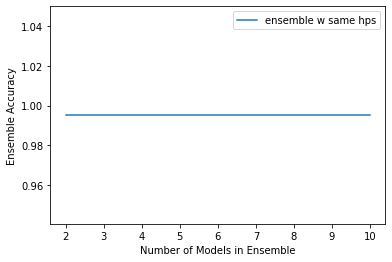

In [ ]:
sns.lineplot(range(2, len(models_ordered)+1), accs_best_hps[1:], label='ensemble w same hps')
plt.ylabel('Ensemble Accuracy')
plt.xlabel('Number of Models in Ensemble')
plt.legend()

plt.show()

Surprisingly, the number of models in the ensemble has no effect on accuracy. Not only that, but the ensembled models actually perform worse than the single best model.

In [ ]:
results_dict[f'ensemble same hps ({np.argmax(accs_best_hps)+1} models)'] = max(accs_best_hps)
print(f'ensemble same hps ({np.argmax(accs_best_hps)+1} models): {max(accs_best_hps):.4f}')

ensemble same hps (2 models): 0.9952


 ## 6.2 Ensembling top models from hyper-parameter tuning

The second ensembling method we will use is stacking. This involves using different models all trained on the same train/validation split. In this case we will take the n best models from the hyperparameter search.

In [ ]:
%%time 
accs = []
n = 15
top_n_models = tuner.get_best_models(n)
for num in range(n):
  top_num_models = top_n_models[:num]
  acc = accuracy_score(y_val_ans, ensemble_models(top_num_models, X_val))
  accs.append(acc)

Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10
132/132 [==============================] - 0s 2ms/step
CPU times: user 1min 16s, sys: 4.27 s, total: 1min 20s
Wall time: 2min 17s


/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


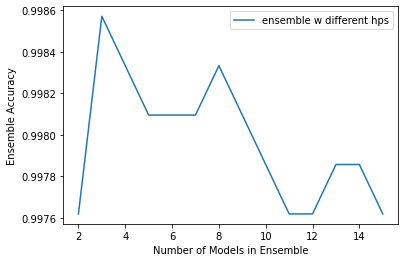

In [ ]:
sns.lineplot(range(2, n+1), accs[1:], label='ensemble w different hps')

plt.ylabel('Ensemble Accuracy')
plt.xlabel('Number of Models in Ensemble')
plt.legend()

plt.show()

In [ ]:
results_dict[f'ensemble diff hps ({np.argmax(accs)+1} models)'] = max(accs)
print(f'ensemble diff hps ({np.argmax(accs)+1} models): {max(accs):.4f}')

ensemble diff hps (3 models): 0.9988


As you can see, an ensemble of the 3 top models gives the best accuracy yet!

# 7. Conclusion

## 7.1 Results Summary

In [ ]:
'''results_dict = {'initial model': 0.9852,
                'data augmented model': 0.9883,
                'best hps model (initial)': 0.9964,
                'best hps model (retrained)': 0.9983,
                'ensemble same hps (2 models)': 0.9952,
                'ensemble diff hps (3 models)': 0.9988}'''

/usr/local/lib/python3.9/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


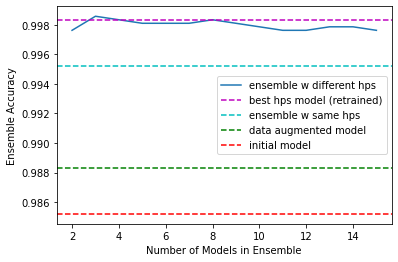

In [ ]:
sns.lineplot(range(2, n+1), accs[1:], label='ensemble w different hps')

plt.axhline(results_dict['best hps model (retrained)'], label='best hps model (retrained)', linestyle='--', c='m')
plt.axhline(results_dict['ensemble same hps (2 models)'], label='ensemble w same hps', linestyle='--', c='c')
plt.axhline(results_dict['data augmented model'], label='data augmented model', linestyle='--', c='g')
plt.axhline(results_dict['initial model'], label='initial model', linestyle='--', c='r')

plt.ylabel('Ensemble Accuracy')
plt.xlabel('Number of Models in Ensemble')
plt.legend()

plt.show()

From the summary of results you can see that the most substantial increases in accuracy came from tuning the model's hyperparameters, however ensembling and data augmentation both have substantial affects.

In [ ]:
results_dict

{'initial model': 0.9852,
 'data augmented model': 0.9883,
 'best hps model (initial)': 0.9964,
 'best hps model (retrained)': 0.9983,
 'ensemble same hps (2 models)': 0.9952,
 'ensemble diff hps (3 models)': 0.9988}

Now that we have chosen our best model, we can test it on Kaggle's hidden test data.

The accuracy on the hidden test data is 0.99567 is slightly lower than on the validation data (0.9988) but this is to be expected as we have used the validation set to tune our model. Despite this, this notebook ranks 94th out of over 3300 entries, which I am very proud of.

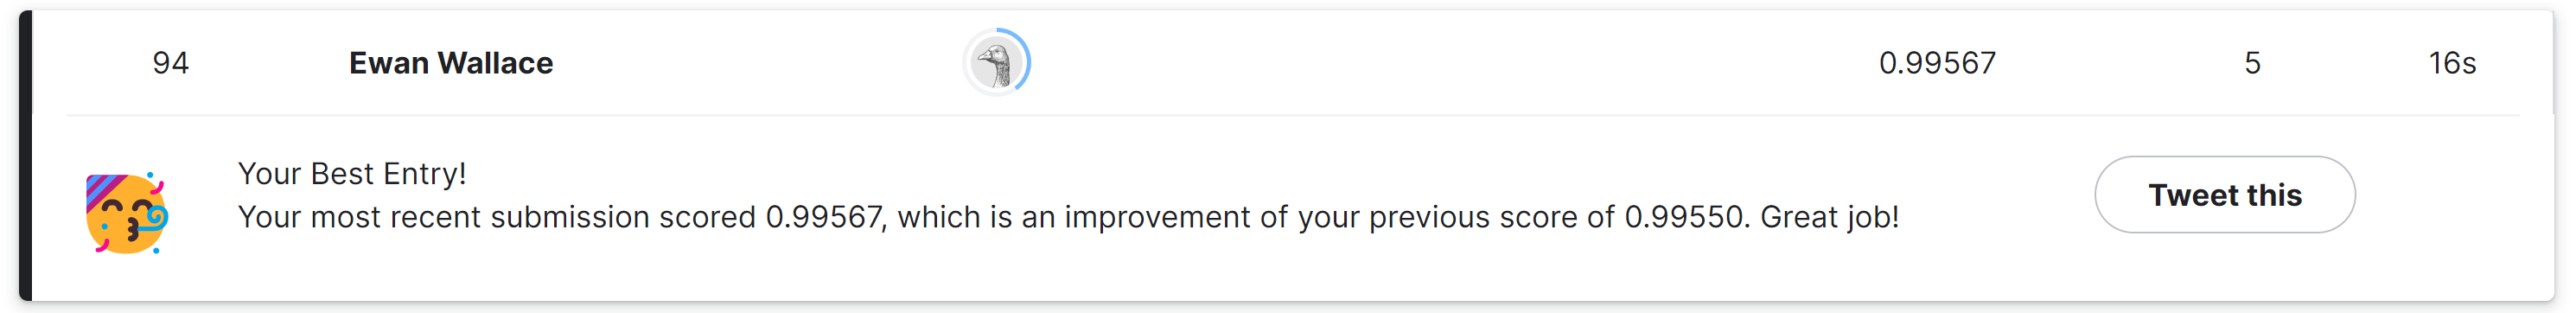

## 7.2 Submission Values

In [ ]:
best_ensemble = tuner.get_best_models(3)

best_hps = tuner.get_best_models(1)[0]
filepath = project_path + 'models/best_hps_4.h5'
best_hps.load_weights(filepath)

submission_model = [best_hps] + best_ensemble[1:]

submission_values = ensemble_models(submission_model, test)
df = pd.DataFrame(submission_values, columns=['Label'])
df['ImageId'] = list(range(1,28001))
df.to_csv(project_path + 'project_submission_3.csv', index=False)

Random seed set as 10
Random seed set as 10
Random seed set as 10
Random seed set as 10


  1/875 [..............................] - ETA: 6:13

  7/875 [..............................] - ETA: 8s  

 15/875 [..............................] - ETA: 6s

875/875 [==============================] - 4s 4ms/step


**Well done for reaching the end, I hope you enjoyed reading this notebook as much as I enjoyed writing it!**